## Getting started with seismic data: downloading, filtering, and extracting amplitudes

These are some codes to download data from a particular seismic station and look at the signal's amplitude over time.  The parameters I've chosen are just for examples, so do play around with any different stations, time periods, or frequencies you think could be interesting.

### The annoying bit: getting Python set up

If you want to run these codes on your computer, it's probably best to install Python via Anaconda: https://www.anaconda.com/products/distribution.  That's normally straightforward, but you never know.

You'll have to install some packages within Python, namely numpy and obspy.  With the graphical version of Anaconda, you go to your environment and type obspy into "search packages" in the right hand corner.

But if you want to run things faster, you should be able to run all the codes via binder, so that everything runs in the cloud rather than on your machine, and you just access a website.  The downside of that approach is that you can't save anything.

In [1]:
# numpy and obspy are packages of codes that we'll find useful
# numpy mostly does array processing and linear algebra
# obspy is a Python package created specifically for seismology (https://docs.obspy.org/)
# matplotlib is for plotting
import numpy as np
import obspy
import matplotlib.pyplot as plt

### Finding stations

You can download seismic data from lots of different locations around the world.  The BGS seismic network is probably a good place to start, as the network is good, and the station information is well-documented in their station book: https://earthquakes.bgs.ac.uk/monitoring/home.html.

This site is also useful for browsing stations: https://ds.iris.edu/gmap/#network=GB&planet=earth.  You can change the network to $*$, which means any network, but if you do that, it's probably a good idea to draw a location box, as otherwise it'll try to load all the seismic stations from around the world, and that'll take ages.  The links there are particularly useful as they tell you when each station operates and which channels are available.


### Downloading data
BGS, along with many other network operators, upload their data to shared repositories run by ORFEUS and IRIS.  Obspy conveniently has codes to connect to these repositories and download data.  We download some data in the two cells below.

In [2]:
# First let's pick a network, station, and channels to examine: this station
# https://ds.iris.edu/mda/GB/WLF1/?starttime=2007-03-14&endtime=2009-12-15
# the ? in the channel label means that we'd like any station that start with HH
nw='GB'
stn='WLF1'
chns='HH?'
print('Network: {:s}, Station {:s}, Channels {:s}'.format(nw,stn,chns))
print('\n')

# we also need to specify a time period of data to download
# Here I've chosen 400 s to speed things up, but times up to a day are practical
# a day at a time is relatively practical
tstart=obspy.UTCDateTime(2015,11,1)
tstop=tstart+400
print('Start and stop times')
print(tstart)
print(tstop)


Network: GB, Station WLF1, Channels HH?


Start and stop times
2015-11-01T00:00:00.000000Z
2015-11-01T00:06:40.000000Z


In [3]:
# then we can download the data

# we need to open a connection to the IRIS repository
from obspy.clients.fdsn import Client
client=Client('IRIS')

# and request the data
st = client.get_waveforms(network=nw,station=stn,location='*',channel=chns,
                          starttime=tstart,endtime=tstop,
                          attach_response=True)
print(st)  

3 Trace(s) in Stream:
GB.WLF1..HHE | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:40.000000Z | 100.0 Hz, 40001 samples
GB.WLF1..HHN | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:40.000000Z | 100.0 Hz, 40001 samples
GB.WLF1..HHZ | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:40.000000Z | 100.0 Hz, 40001 samples


The downloaded data is stored in an obspy "Stream" object that I've called st.  We can extract the data from this object, or we can ask the object to manipulate the data in various ways.

Note that the Stream object contains three "Traces," one for each channel.  Often we'll have to go into the Trace object for detailed manipulation.

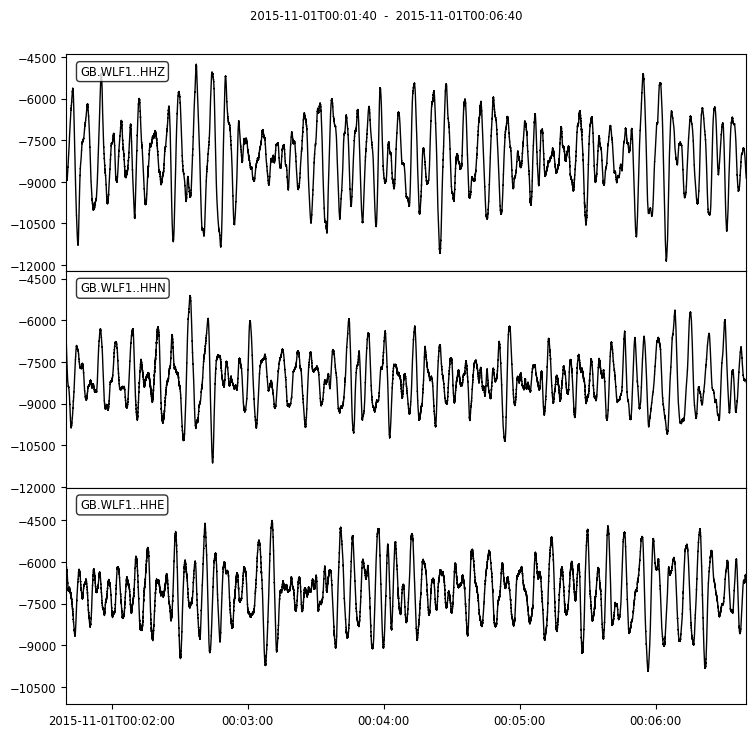

In [4]:
# we can plot the data, or part of the data
st.plot(starttime=tstart+100,endtime=tstop);

Channel Response
	From M/S (Velocity in Meters per Second) to COUNTS (Digital Counts)
	Overall Sensitivity: 9.4086e+08 defined at 1.000 Hz
	5 stages:
		Stage 1: PolesZerosResponseStage from M/S to V, gain: 3007
		Stage 2: CoefficientsTypeResponseStage from V to COUNTS, gain: 312890
		Stage 3: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 4: FIRResponseStage from COUNTS to COUNTS, gain: 1
		Stage 5: FIRResponseStage from COUNTS to COUNTS, gain: 1


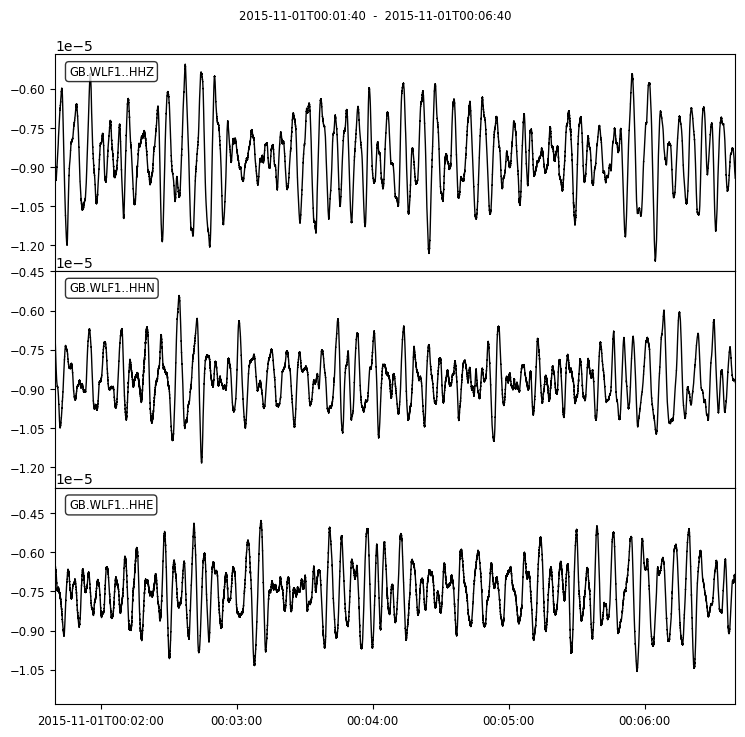

In [5]:
# One issue here is the units: they're in "counts", which is just a unit that's convenient 
# to the instrument.  But we'd like ground shaking, so let's correct for the conversion
# between instrument counts and ground velocity.
st.remove_sensitivity()

# normally removing the sensitivity (aka the gain) gets you ground velocity in m/s
# but we can check if we look at one of the traces and examine the response

# the first trace
tr=st[0]

# and let's print the response
# note that we downloaded this response---the instrumental info, 
# when we grabbed the data from IRIS in the get_waveforms command above
print(tr.stats.response)

# it says m/s to counts, so let's go ahead and replot the seismograms, which now have
# sensible numbers (in m/s) on the y axis
st.plot(starttime=tstart+100,endtime=tstop);

### Filtering

That's interesting, but the data seem to be dominated by a 5-s frequency band.  Maybe we should make a copy of the data and filter it to focus on higher frequencies: say 1-10 Hz.

This is the frequency band that we're really interested in.  The frequencies are relatively high, so the waves should dissipate quickly, and we should recover information about what's going on locally.  Though do have a play in looking at lower or even higher frequencies.  (Just change the 1 and 10 above.)

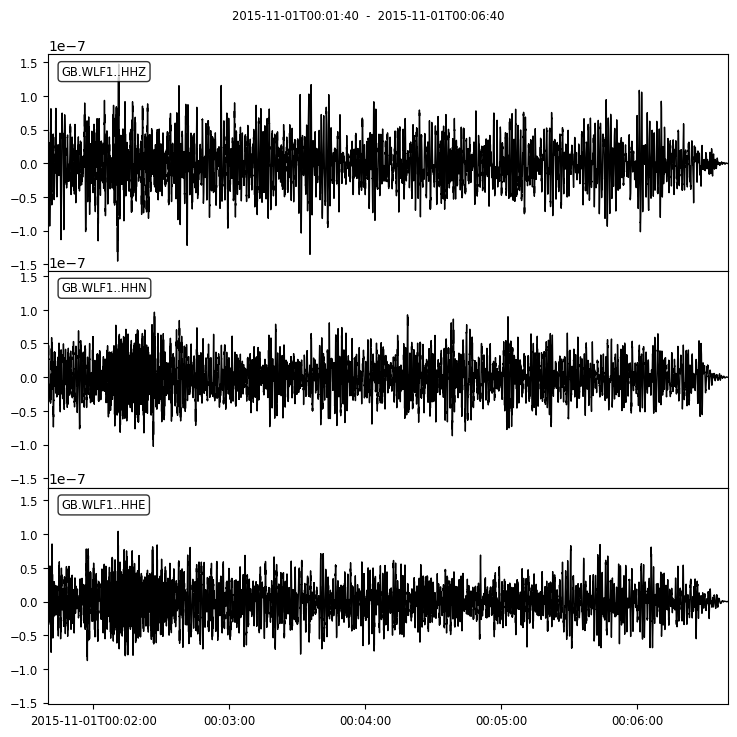

In [6]:
stf=st.copy()

# Before we filter, it's a good idea to remove a mean and then force the beginning and end of the data to
# taper to zero.
stf.detrend()
stf.taper(type='hann',max_percentage=0.1,max_length=20.)

# To filter, we'll use a command "filter" that's built into the Stream and Trace objects.
stf.filter('bandpass',freqmin=1,freqmax=10)
stf.plot(starttime=tstart+100,endtime=tstop);

### Extracting the amplitude

Now that we've filtered to the frequency range of interest, we may want to extract the signal's amplitude through time.  

The Stream object doesn't have a built-in command this time, so we'll have to extract the data from the objects, manipulate the data, and then replace the old data with the modified data.


The original data
[  0.00000000e+00  -1.55035763e-17   6.06022434e-18 ...,   2.48480834e-10
   2.50872548e-10   2.51949751e-10]
The envelope
[  2.21452012e-10   6.94508690e-11   7.70705115e-11 ...,   2.50014645e-10
   2.54019431e-10   3.29036754e-10]

The original data
[  0.00000000e+00  -7.05945525e-17  -9.28286545e-16 ...,  -1.55572746e-11
  -1.10680910e-11  -6.71725630e-12]
The envelope
[  2.70422448e-11   2.02100916e-11   1.75278384e-11 ...,   3.86373665e-11
   3.48936830e-11   3.29250150e-11]

The original data
[  0.00000000e+00   1.97945543e-17   1.61552190e-16 ...,  -8.37998619e-11
  -7.63404910e-11  -6.90148785e-11]
The envelope
[  1.83684174e-10   1.36259649e-10   1.32708588e-10 ...,   1.79970499e-10
   1.73577176e-10   2.03800665e-10]


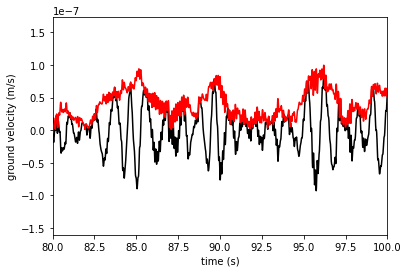

In [7]:
# to compute the envlope of a time series, we'll use obspy's "envelope" command
from obspy.signal.filter import envelope

# let's go ahead and make a copy of the Stream object.  We'll modify the data in this object so that it becomes the envelope.
env=stf.copy()

# we'll manipulate each Trace in the Stream, so let's use a for loop to go through them
for tr in env:
    # now we need to grab the data from the Trace
    data = tr.data
    print('\nThe original data')
    print(data)
    
    # and we'll make an envelope of that 
    edata=envelope(data)
    print('The envelope')
    print(edata)
    
    # let's replace the data in the envelope trace
    tr.data=edata

# the data from the last trace is still available
# let's plot it to see what the envelope is doing
plt.axes();
tms=tr.times()
plt.plot(tms,data,color='k')
plt.plot(tms,edata,color='r')
plt.xlabel('time (s)')
plt.ylabel('ground velocity (m/s)')
plt.xlim([80,100]);
    

We can also use the built-in function to plot the envelopes, as they're saved in the Stream object.  

We may now also note that the envelope function is sampled at very high frequency.  It's capturing variations in amplitudes on timescales of 0.01s.  Probably we're not interested in changes in amplitude at that timescale, so let's lowpass filter to look at longer timescales.  And to save space in memory, let's resample so that we only have one point per s.

3 Trace(s) in Stream:
GB.WLF1..HHE | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:40.000000Z | 100.0 Hz, 40001 samples
GB.WLF1..HHN | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:40.000000Z | 100.0 Hz, 40001 samples
GB.WLF1..HHZ | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:40.000000Z | 100.0 Hz, 40001 samples


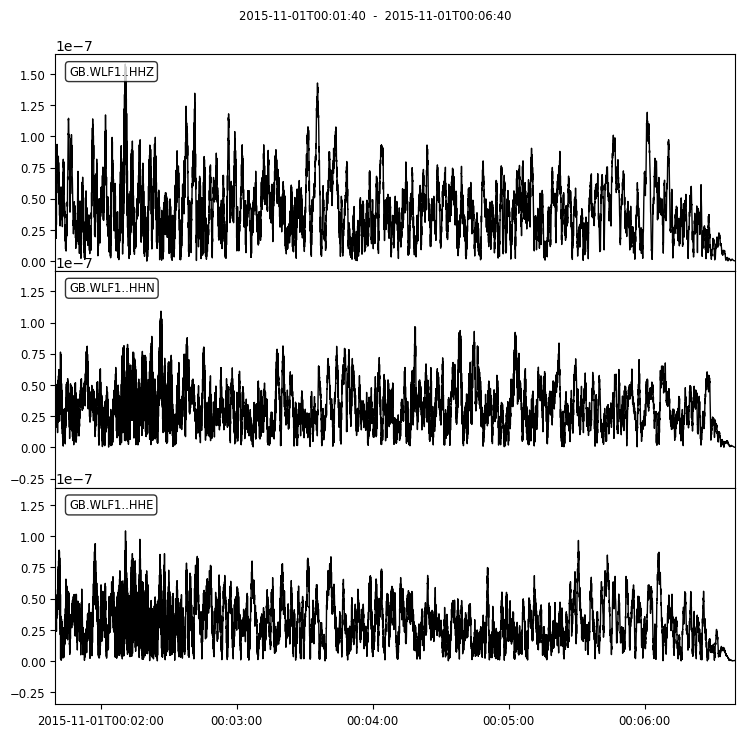

In [8]:
# first let's plot the envelope and print their info
# note the sampling rate (100.0 Hz) and the number of samples
print(env)
env.plot(starttime=tstart+100,endtime=tstop);

In [10]:
# and let's smooth the envelopes

# again before we filter, it's good practice to taper the end sections to zero
env.taper(type='hann',max_length=20,max_percentage=0.1)

# note that here the frequency is in Hz (1/s)
env.filter('lowpass',freq=1/10)

# and resample
env.resample(sampling_rate=1)

print(env)

3 Trace(s) in Stream:
GB.WLF1..HHE | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:39.000000Z | 1.0 Hz, 400 samples
GB.WLF1..HHN | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:39.000000Z | 1.0 Hz, 400 samples
GB.WLF1..HHZ | 2015-11-01T00:00:00.000000Z - 2015-11-01T00:06:39.000000Z | 1.0 Hz, 400 samples


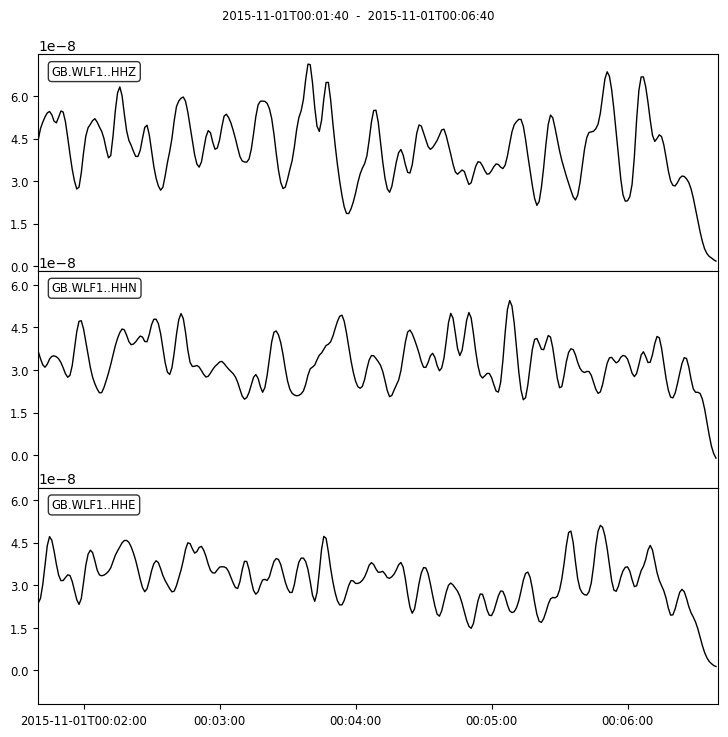

In [11]:
# we can replot to see how we've done
env.plot(starttime=tstart+100,endtime=tstop);

That's not a bad start.  We could now think about saving this data or looking at longer time periods.  Keep in mind that we should really throw away any information from the beginning and end, where the taper has significantly affected the data.